# LLMs and Knowledge Graphs
##### Web Based Systems 2025, [FCSE](https://finki.ukim.mk/)

LLMs are trained on enormous bodies of data but they aren’t trained on your data. Retrieval-Augmented Generation (RAG) solves this problem by adding your data to the data LLMs already have access to. You will see references to RAG frequently in this documentation.

In RAG, your data is loaded and prepared for queries or “indexed”. User queries act on the index, which filters your data down to the most relevant context. This context and your query then go to the LLM along with a prompt, and the LLM provides a response.

Even if what you’re building is a chatbot or an agent, you’ll want to know RAG techniques for getting data into your application.

In this auditorium exercise we will see how we can use OpenAI's ChatGPT to generate responses to our questions based on the data that we have.

We will use a small movies dataset and see if we can use LLMs as reasoning leyers over graph structures.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

# Vector Database

LLMs offer a natural language interface between humans and data. Widely available models come pre-trained on huge amounts of publicly available data like Wikipedia, mailing lists, textbooks, source code and more.

However, while LLMs are trained on a great deal of data, they are not trained on your data, which may be private or specific to the problem you’re trying to solve. It’s behind APIs, in SQL databases, or trapped in PDFs and slide decks.

Langchain solves this problem by connecting to these data sources and adding your data to the data LLMs already have. This is often called Retrieval-Augmented Generation (RAG). RAG enables you to use LLMs to query your data, transform it, and generate new insights. You can ask questions about your data, create chatbots, build semi-autonomous agents, and more.

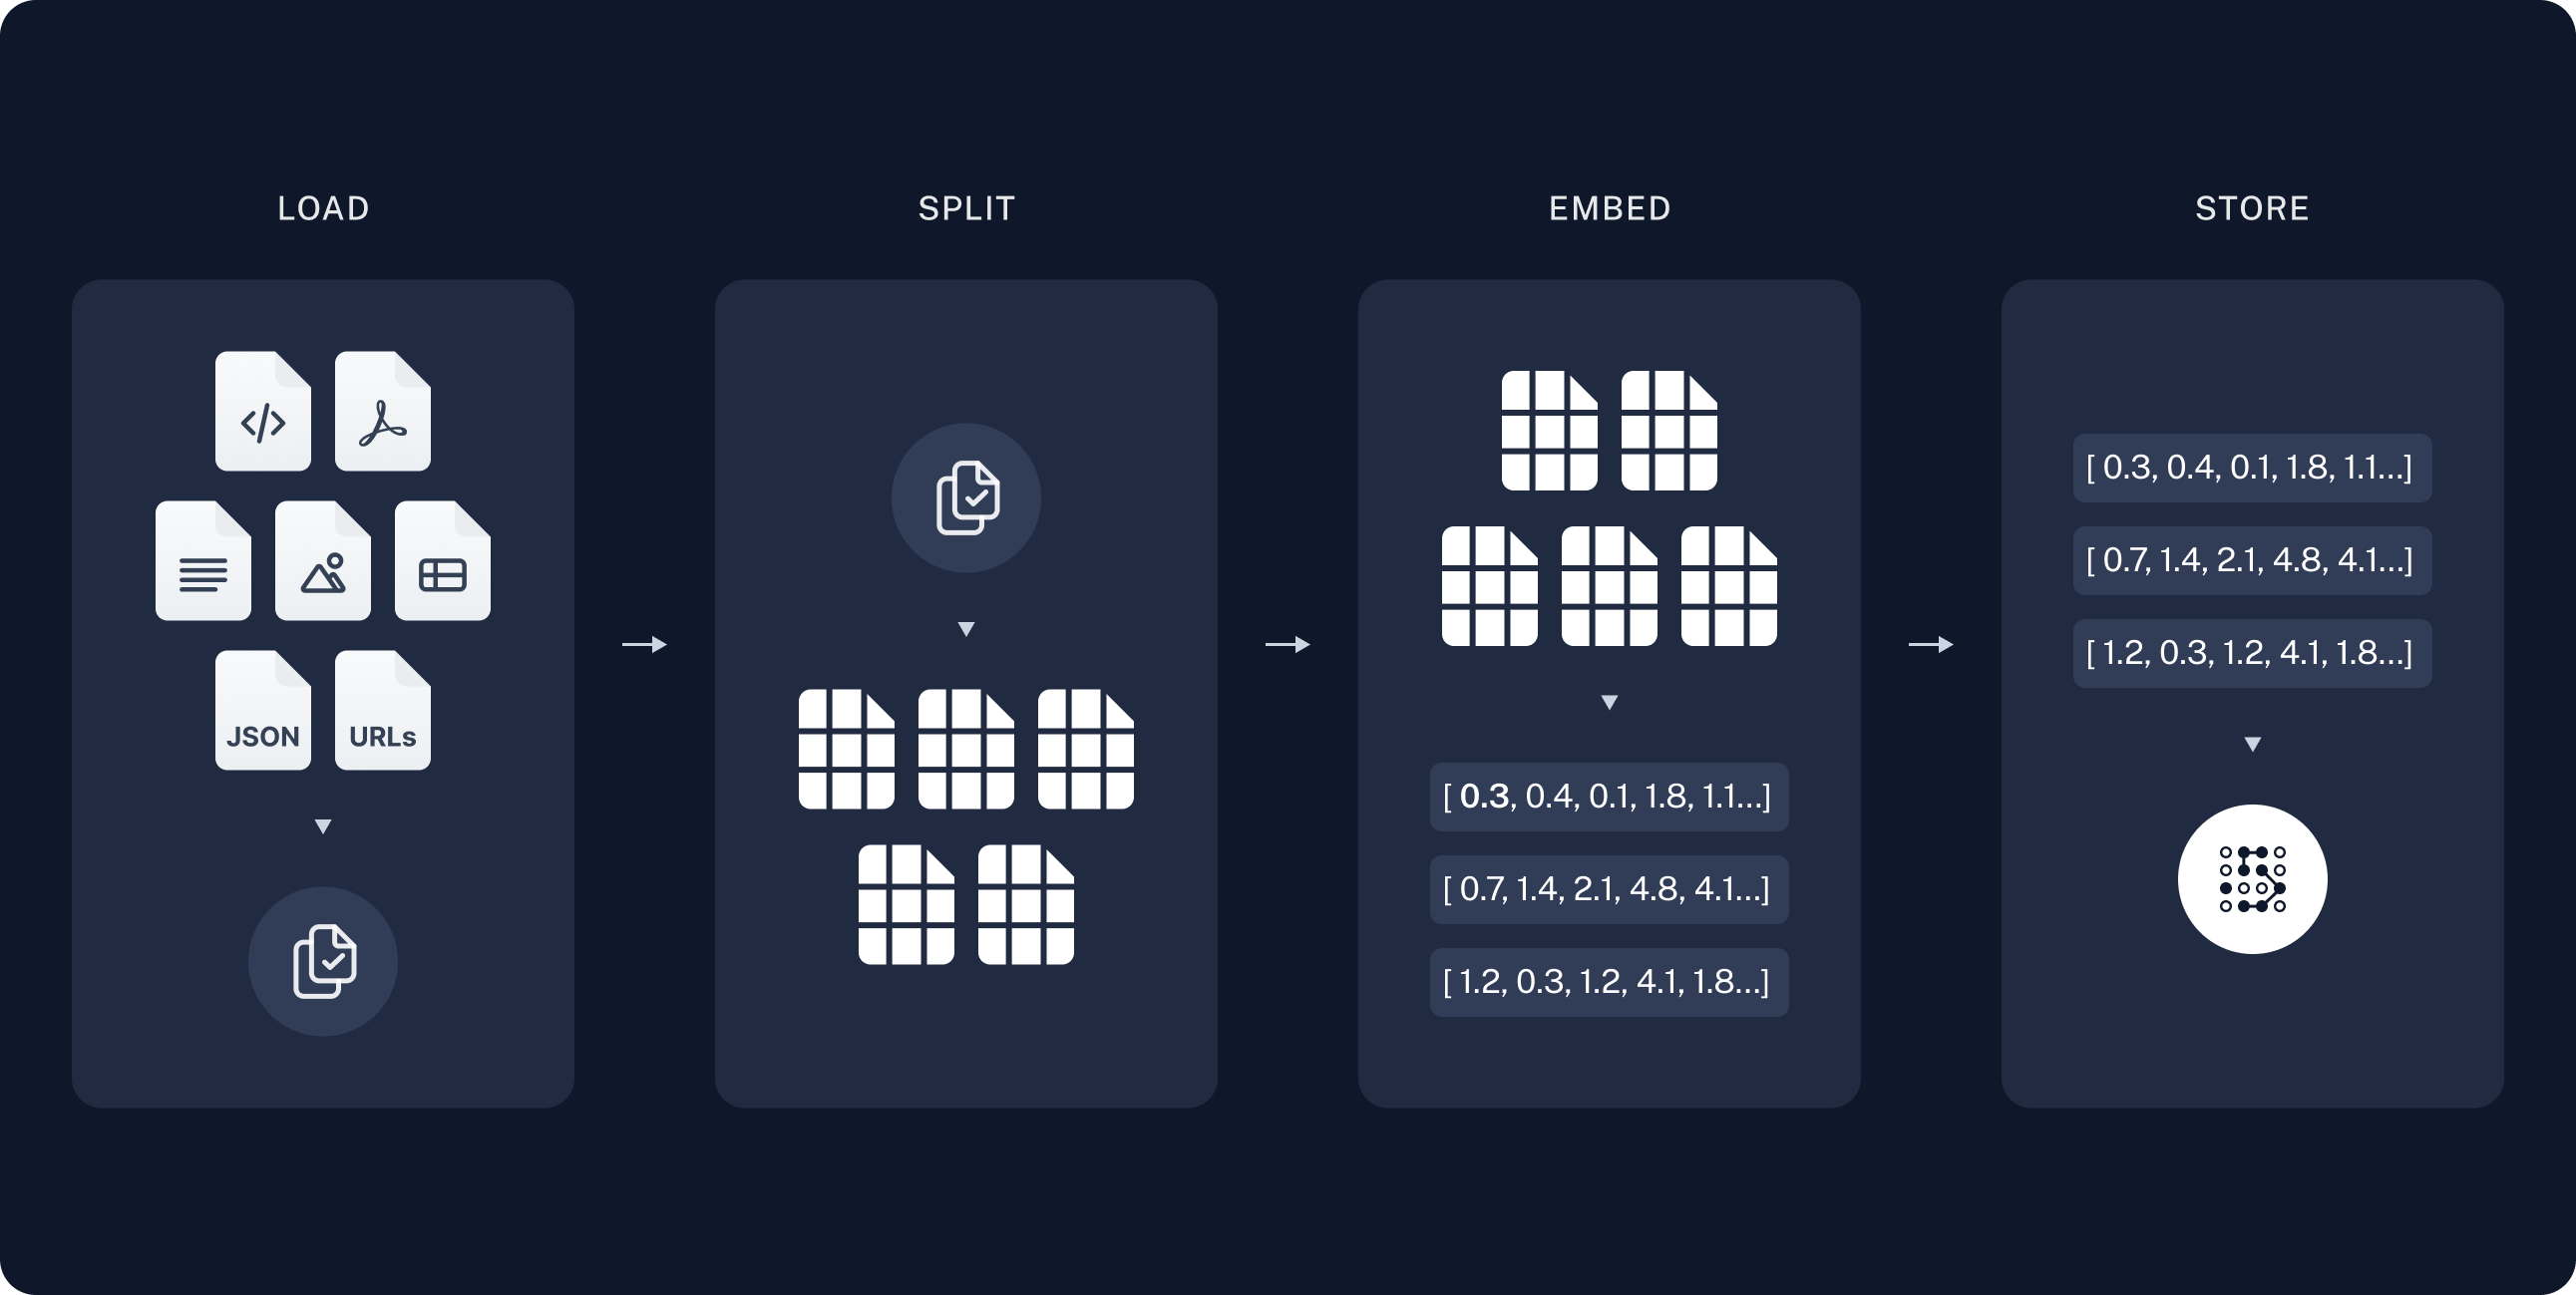

Indexing
- Load: First we need to load our data. This is done with Document Loaders.
- Split: Text splitters break large Documents into smaller chunks. This is useful both for indexing data and passing it into a model, as large chunks are harder to search over and won't fit in a model's finite context window.
- Store: We need somewhere to store and index our splits, so that they can be searched over later. This is often done using a VectorStore and Embeddings model.

In [2]:
from langchain_openai import OpenAIEmbeddings

In [3]:
embeddings = OpenAIEmbeddings()

In [4]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)  # Stores the embeddings in memory as a dictionary

In [5]:
# Load
from langchain_community.document_loaders import DirectoryLoader

loader = DirectoryLoader("./data/")  # Loads all files from the given directory path
docs = loader.load()

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

#Split
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,  # chunk size (characters)
    chunk_overlap=30,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split headlines into {len(all_splits)} sub-documents.")

Split headlines into 199 sub-documents.


In [7]:
#Store
document_ids = vector_store.add_documents(documents=all_splits)

In [8]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "Use the context to answer the question."),
    ("human", "Context:\n{context}\n\nQuestion:\n{question}")
])

In [9]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='Use the context to answer the question.'), additional_kwargs={}), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Context:\n{context}\n\nQuestion:\n{question}'), additional_kwargs={})])

- Retrieve: Given a user input, relevant splits are retrieved from storage using a Retriever.
- Generate: A ChatModel / LLM produces an answer using a prompt that includes both the question with the retrieved data

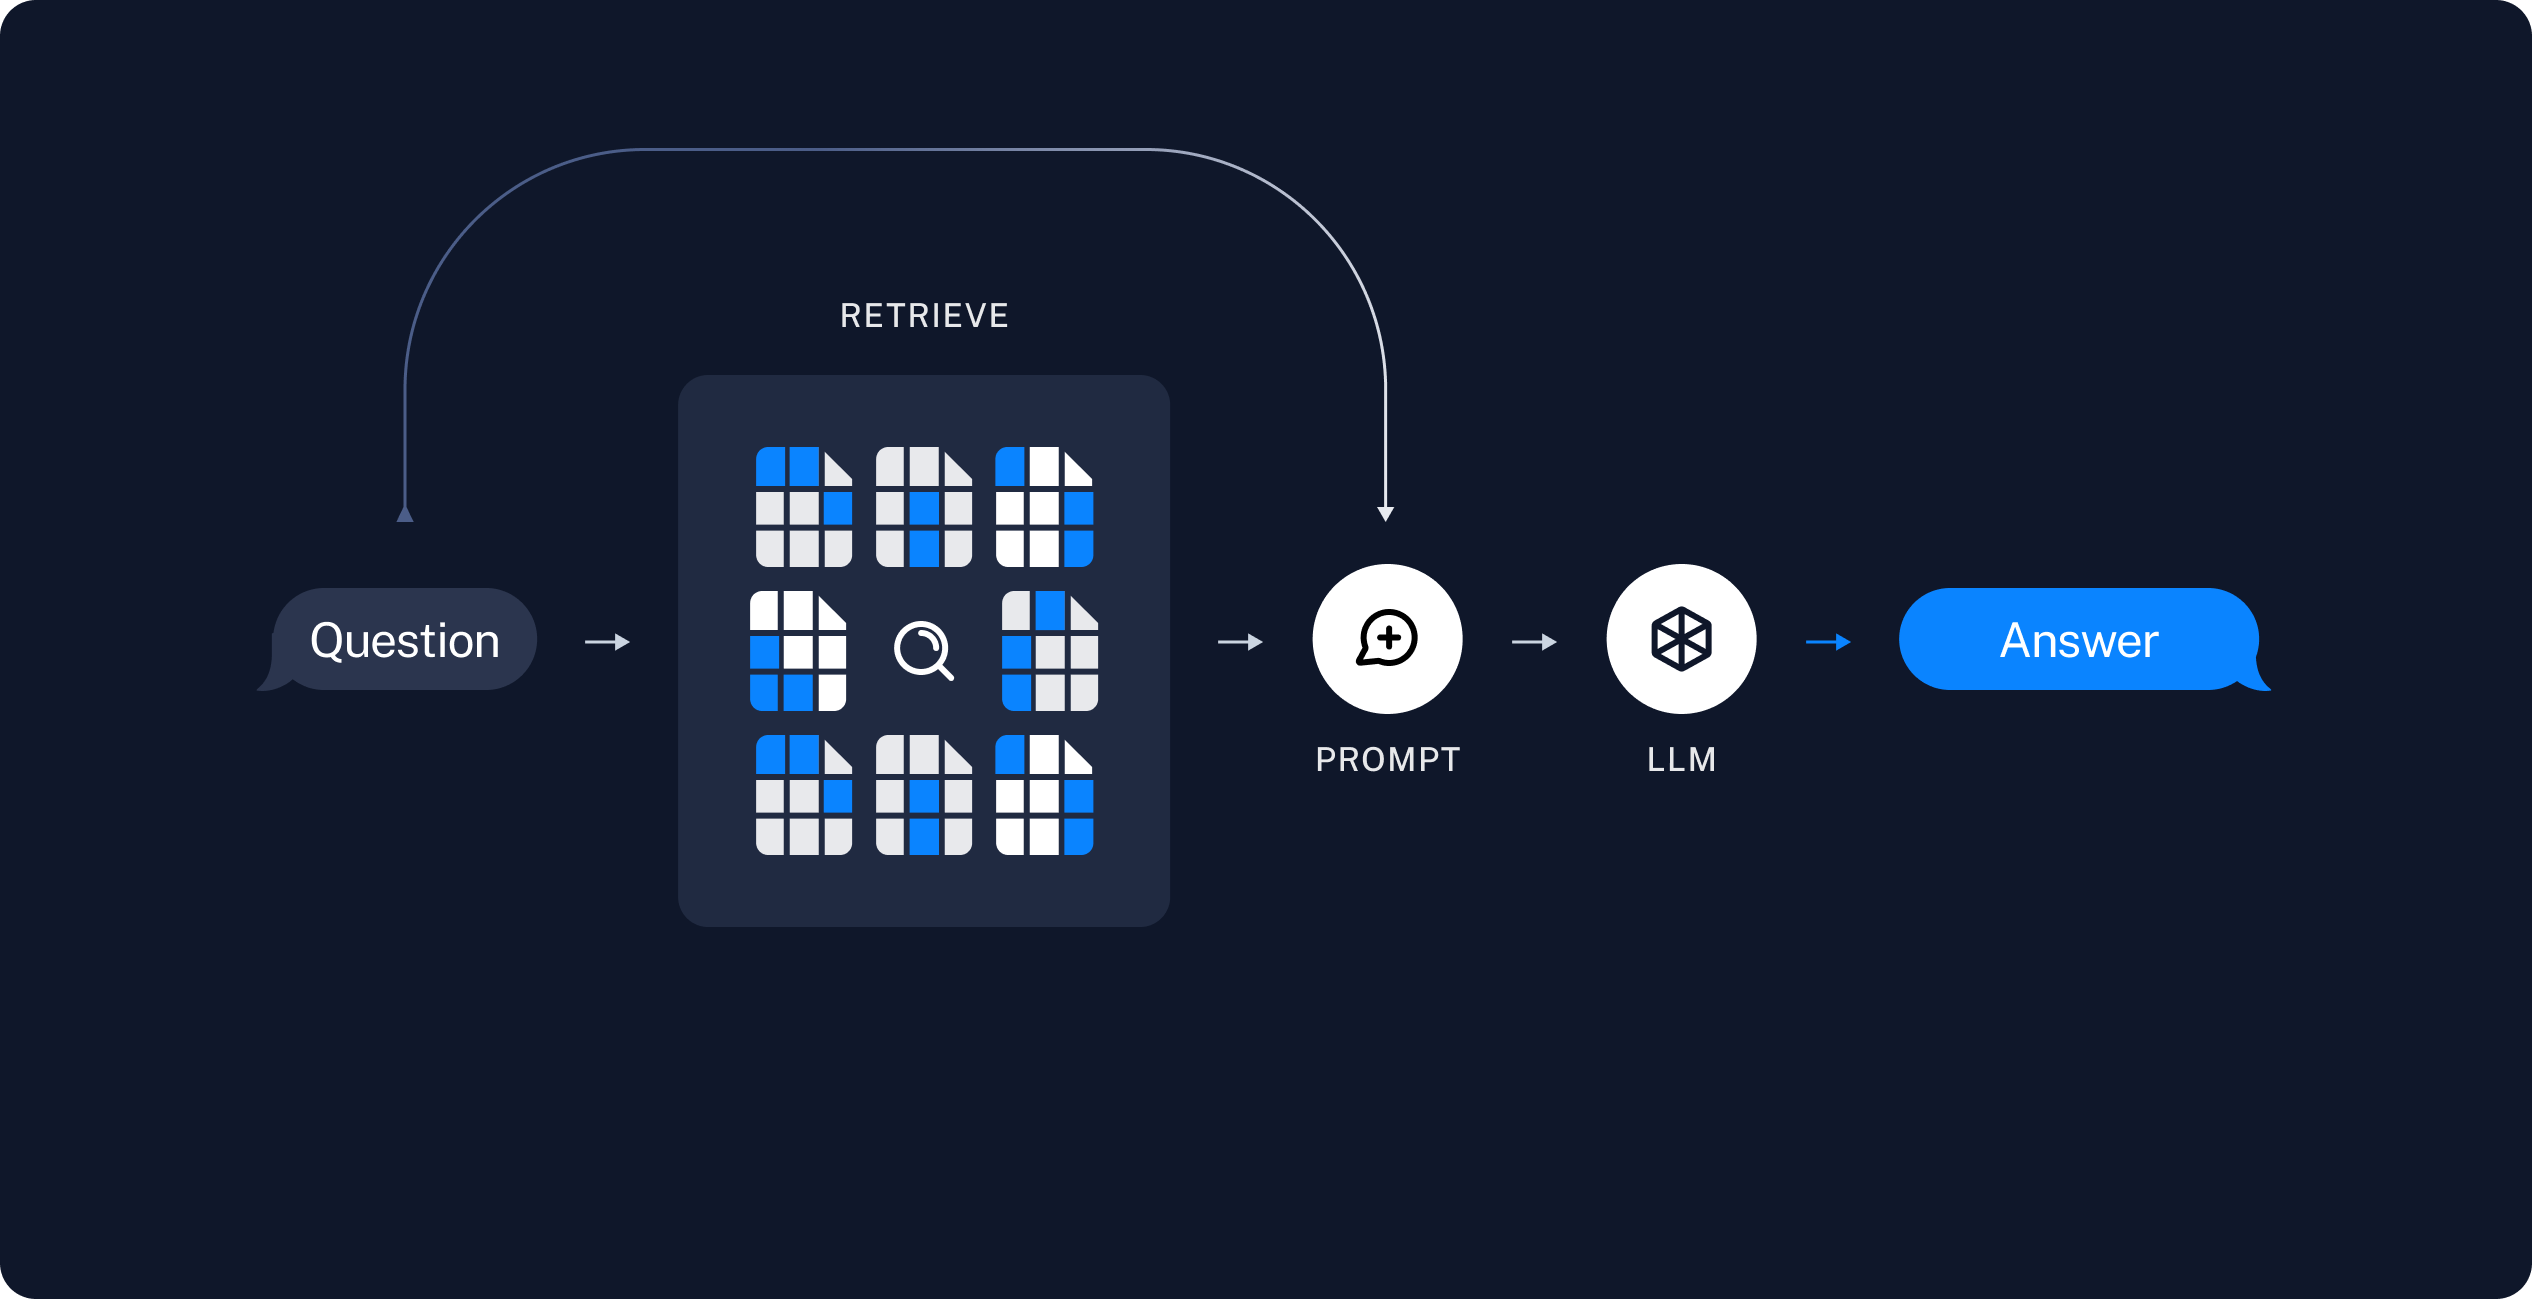

In [10]:
def retrieve(question):
    retrieved_docs = vector_store.similarity_search(question)
    return {"context": retrieved_docs}


def generate(llm, question, context_docs):
    docs_content = "\n\n".join(doc.page_content for doc in context_docs['context'])
    messages = prompt.invoke({"question": question, "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [11]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4o', temperature=0)

In [12]:
question = "How much increase of sales did the Department Store Division report?"

In [13]:
retrieved_docs = retrieve(question)

In [14]:
retrieved_docs

{'context': [Document(id='2547c18e-5af6-4a4f-84a0-220558c190ce', metadata={'source': 'data/headline_72.txt', 'start_index': 0}, page_content='The Department Store Division reported an increase in sales of 4 per cent'),
  Document(id='98544377-c3fe-43c0-91e6-ed93ffdecc57', metadata={'source': 'data/headline_42.txt', 'start_index': 0}, page_content="Adjusted for changes in the Group structure , the Division 's net sales increased by 1.7 %"),
  Document(id='6a7d5d0c-b25e-47ad-be42-9ea3a7c47dd4', metadata={'source': 'data/headline_28.txt', 'start_index': 0}, page_content='Sales increased due to growing market rates and increased operations'),
  Document(id='10d7c547-b78b-47de-bb13-648764270fe4', metadata={'source': 'data/headline_59.txt', 'start_index': 0}, page_content='Net sales grew in the period to  x20ac 402 million $ 585US million from  x20ac 401 million in 2006')]}

In [15]:
answer = generate(llm, question, retrieved_docs)

In [16]:
answer

{'answer': 'The Department Store Division reported an increase in sales of 4 percent.'}

# Graph Database

In this exercise we'll go over the basic ways to create a Q&A chain over a graph database. These systems will allow us to ask a question about the data in a graph database and get back a natural language answer. We will show a simple out-of-the-box option.

### Architecture
At a high-level, the steps of most graph chains are:

- Convert question to a graph database query: Model converts user input to a graph database query (e.g. Cypher).
- Execute graph database query: Execute the graph database query.
- Answer the question: Model responds to user input using the query results.


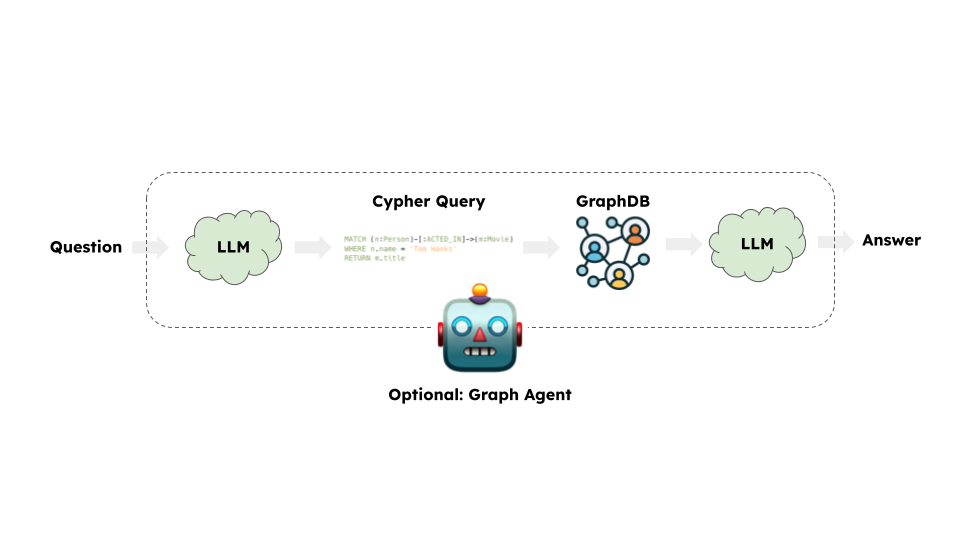

In [17]:
from langchain_neo4j import Neo4jGraph

In [18]:
graph = Neo4jGraph()

In [19]:
movies_query = """
LOAD CSV WITH HEADERS FROM
'https://raw.githubusercontent.com/tomasonjo/blog-datasets/main/movies/movies_small.csv'
AS row
MERGE (m:Movie {id:row.movieId})
SET m.released = date(row.released),
    m.title = row.title,
    m.imdbRating = toFloat(row.imdbRating)
FOREACH (director in split(row.director, '|') |
    MERGE (p:Person {name:trim(director)})
    MERGE (p)-[:DIRECTED]->(m))
FOREACH (actor in split(row.actors, '|') |
    MERGE (p:Person {name:trim(actor)})
    MERGE (p)-[:ACTED_IN]->(m))
FOREACH (genre in split(row.genres, '|') |
    MERGE (g:Genre {name:trim(genre)})
    MERGE (m)-[:IN_GENRE]->(g))
"""

graph.query(movies_query)

[]

## Graph Schema

In order for an LLM to be able to generate a Cypher statement, it needs information about the graph schema. When you instantiate a graph object, it retrieves the information about the graph schema. If you later make any changes to the graph, you can run the `refresh_schema` method to refresh the schema information.

In [20]:
graph.refresh_schema()

In [21]:
print(graph.schema)

Node properties:
Movie {id: STRING, released: DATE, title: STRING, imdbRating: FLOAT}
Person {name: STRING}
Genre {name: STRING}
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


In [22]:
enhanced_graph = Neo4jGraph(enhanced_schema=True)

In [23]:
print(enhanced_graph.schema)

Node properties:
- **Movie**
  - `id`: STRING Example: "1"
  - `released`: DATE Min: 1964-12-16, Max: 1996-09-15
  - `title`: STRING Example: "Toy Story"
  - `imdbRating`: FLOAT Min: 2.4, Max: 9.3
- **Person**
  - `name`: STRING Example: "John Lasseter"
- **Genre**
  - `name`: STRING Example: "Adventure"
Relationship properties:

The relationships:
(:Movie)-[:IN_GENRE]->(:Genre)
(:Person)-[:DIRECTED]->(:Movie)
(:Person)-[:ACTED_IN]->(:Movie)


The `enhanced_schema` option enriches property information by including details such as minimum and maximum values for floats and dates, as well as example values for string properties. This additional context helps guide the LLM toward generating more accurate and effective queries.

Great! We've got a graph database that we can query. Now let's try hooking it up to an LLM.

## GraphQACypherChain

Let's use a simple out-of-the-box chain that takes a question, turns it into a Cypher query, executes the query, and uses the result to answer the original question.

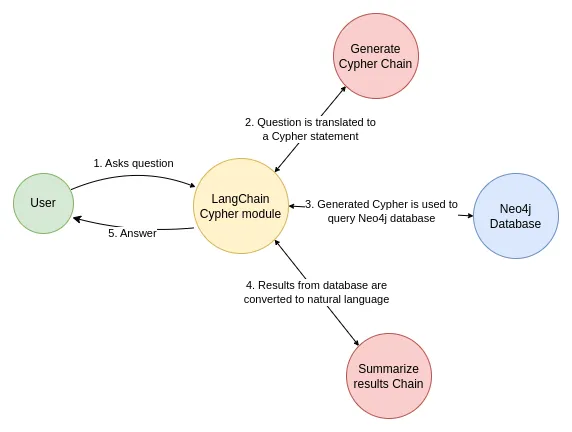


LangChain comes with a built-in chain for this workflow that is designed to work with Neo4j: [GraphCypherQAChain](/docs/integrations/graphs/neo4j_cypher)

In [24]:
from langchain_neo4j import GraphCypherQAChain


In [25]:
chain = GraphCypherQAChain.from_llm(llm=llm, graph=enhanced_graph, verbose=True, allow_dangerous_requests=True)

In [26]:
response = chain.invoke({"query": "What was the cast of the Toy Story?"})



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person)-[:ACTED_IN]->(m:Movie {title: "Toy Story"})
RETURN p.name AS cast

Full Context:
[{'cast': 'Jim Varney'}, {'cast': 'Tim Allen'}, {'cast': 'Tom Hanks'}, {'cast': 'Don Rickles'}]

> Finished chain.


In [27]:
response

{'query': 'What was the cast of the Toy Story?',
 'result': 'Jim Varney, Tim Allen, Tom Hanks, and Don Rickles were the cast of Toy Story.'}

## Generating SPARQL Queries Using LLMs and An Ontology Definition

Graph databases are an excellent choice for applications based on network-like models. To standardize the syntax and semantics of such graphs, the W3C recommends Semantic Web Technologies, cp. Semantic Web.

SPARQL serves as a query language analogously to SQL or Cypher for these graphs. This notebook demonstrates the application of LLMs as a natural language interface to a graph database by generating SPARQL.

Disclaimer: To date, SPARQL query generation via LLMs is still a bit unstable. Be especially careful with UPDATE queries, which alter the graph.

In [28]:
from langchain_community.graphs import RdfGraph

In [29]:
graph = RdfGraph(
    source_file="https://raw.githubusercontent.com/peshevskidimitar/foaf_me/refs/heads/main/foaf.ttl",
    standard='rdf',
    local_copy='me.ttl'
)

In [30]:
graph.load_schema()

In [31]:
print(graph.get_schema)

In the following, each IRI is followed by the local name and optionally its description in parentheses. 
The RDF graph supports the following node types:
<http://xmlns.com/foaf/0.1/PersonalProfileDocument> (PersonalProfileDocument, None), <http://xmlns.com/foaf/0.1/Person> (Person, None)
The RDF graph supports the following relationships:
<http://xmlns.com/foaf/0.1/givenname> (givenname, None), <http://xmlns.com/foaf/0.1/primaryTopic> (primaryTopic, None), <http://www.w3.org/2000/01/rdf-schema#seeAlso> (seeAlso, None), <http://xmlns.com/foaf/0.1/name> (name, None), <http://xmlns.com/foaf/0.1/title> (title, None), <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> (type, None), <http://xmlns.com/foaf/0.1/depiction> (depiction, None), <http://xmlns.com/foaf/0.1/maker> (maker, None), <http://xmlns.com/foaf/0.1/schoolHomepage> (schoolHomepage, None), <http://xmlns.com/foaf/0.1/family_name> (family_name, None), <http://xmlns.com/foaf/0.1/nick> (nick, None), <http://xmlns.com/foaf/0.1/knows> 

In [32]:
prompt = """You will receive a description of an RDF ontology in the Turtle format.

Your task is to generate a SPARQL query based on the provided ontology scheme and a user
question stated in natural language.

*** DO NOT GENERATE ANY ADDITIONAL TEXT! ***

Here is provided scheme for the ontology:
#######
# Ontology scheme

{scheme_ontology}
#######

Based on the user question YOU NEED TO PROVIDE A SPARQL query using the ontology you have.
Your answer MUST PROVIDE ONLY THE GENERATED SPARQL QUERY.

# User question
{user_question}

# Answer
"""

In [33]:
response = llm.invoke(prompt.format(scheme_ontology=graph.get_schema, user_question="What's Dimitar's work website?"))

In [34]:
print(response.content)

```sparql
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?workplaceHomepage WHERE {
  ?person foaf:givenname "Dimitar" .
  ?person foaf:workplaceHomepage ?workplaceHomepage .
}
```


In [35]:
question2 = "Give me all the names and surnames of the people that Dimitar knows?"

In [36]:
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template(prompt)

parsed_prompt = prompt_template.invoke({"scheme_ontology": graph.get_schema, "user_question": question2})

In [37]:
print(parsed_prompt.text)

You will receive a description of an RDF ontology in the Turtle format.

Your task is to generate a SPARQL query based on the provided ontology scheme and a user
question stated in natural language.

*** DO NOT GENERATE ANY ADDITIONAL TEXT! ***

Here is provided scheme for the ontology:
#######
# Ontology scheme

In the following, each IRI is followed by the local name and optionally its description in parentheses. 
The RDF graph supports the following node types:
<http://xmlns.com/foaf/0.1/PersonalProfileDocument> (PersonalProfileDocument, None), <http://xmlns.com/foaf/0.1/Person> (Person, None)
The RDF graph supports the following relationships:
<http://xmlns.com/foaf/0.1/givenname> (givenname, None), <http://xmlns.com/foaf/0.1/primaryTopic> (primaryTopic, None), <http://www.w3.org/2000/01/rdf-schema#seeAlso> (seeAlso, None), <http://xmlns.com/foaf/0.1/name> (name, None), <http://xmlns.com/foaf/0.1/title> (title, None), <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> (type, None), 

In [38]:
response = llm.invoke(parsed_prompt)

In [39]:
print(response.content)

```sparql
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?name ?surname
WHERE {
  ?person foaf:name "Dimitar" .
  ?person foaf:knows ?knownPerson .
  ?knownPerson foaf:name ?name .
  ?knownPerson foaf:family_name ?surname .
}
```
